In [1]:
import sys
from glob import glob

import h5py
import numpy as np

import pandas as pd
from datetime import datetime, timedelta

from scipy.stats import spearmanr, mannwhitneyu, ks_2samp
from scipy.stats import genextreme as gev
#from scipy.stats.mstats import kruskalwallis

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/utils')
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/fcstpp/')

from fcstpp import metrics
from fcstpp import utils as fu

import graph_utils as gu
import data_utils as du
import BCH_utils as bu
from namelist import *

In [3]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [4]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

# Station info

Three watershed groups: 

* South Coast
* Southern Interior
* Northeast BC

In [5]:
with h5py.File(save_dir+'BCH_wshed_groups.hdf', 'r') as h5io:
    flag_sw = h5io['flag_sw'][...]
    flag_si = h5io['flag_si'][...]
    flag_n = h5io['flag_n'][...]
    
FLAGs = (flag_sw, flag_si, flag_n)

In [6]:
# # identified +/-0.1 mm precision stations (others are +/- 1 mm) 
# # (not helpful)
# flag_hires = np.array([True , False, False, False, False, False, False, False, True , False, False,
#                        False, False, False, False, False, True , True , True , False, False,
#                        False, False, False, True , False, False, False, True , False, False,
#                        True , False, False, False, True , False, False, False, True , False,
#                        True , False, False, False, False, False, True , False, True , False,
#                        False, False, False, False, False, False, True , False, False, False,
#                        False, False, False, True , False, False, False, False, False, False,
#                        False, False, False, False, False, False, False, False, False, False,
#                        False, False, False,])

# Extreme value analysis on daily (discarded)

In [7]:
# def rolling_window_max(data, radius=15, thres_nan=15):
#     L, N_stn = data.shape
#     out = np.empty((L, N_stn))
    
#     for i in range(L):
#         inds = fu.window_slider_cycled_1d(i, L, radius)
#         data_sub = data[inds, :]
        
#         for n in range(N_stn):
#             nan_ = np.sum(np.isnan(data_sub[:, n]))
#             if nan_ >= thres_nan:
#                 out[i, n] = np.nan
#             else:
#                 out[i, n] = np.nanmax(data_sub[:, n])
#     return out

In [8]:
# with h5py.File(save_dir+'BCH_ERA5_1D_pairs.hdf', 'r') as h5io:
#     ERA5_obs = h5io['ERA5_obs'][...]
#     BCH_obs = h5io['BCH_obs'][...]
    
# ERA5_max = rolling_window_max(ERA5_obs, radius=15, thres_nan=30)
# BCH_max = rolling_window_max(BCH_obs, radius=15, thres_nan=30)

In [9]:
# gray = '0.9'
# window_size = 31
# N_days = 366 + 365*3
# N_effective = N_days#int(N_days/window_size)
# seed_ = 999

# fig = plt.figure(figsize=(13, 6), dpi=dpi_)
# gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1])

# ax00 = plt.subplot(gs[0, 0])
# ax01 = plt.subplot(gs[0, 1])
# ax02 = plt.subplot(gs[0, 2])

# ax10 = plt.subplot(gs[1, 0])
# ax11 = plt.subplot(gs[1, 1])
# ax12 = plt.subplot(gs[1, 2])

# pad = 0.0
# ax_a1 = fig.add_axes([0.0-pad, -0.425, 1/3.2+pad, 0.3])
# ax_a2 = fig.add_axes([1.1/3.2-pad, -0.425, 1/3.2+pad, 0.3])
# ax_a3 = fig.add_axes([2.2/3.2-pad, -0.425, 1/3.2+pad, 0.3])

# plt.subplots_adjust(0, 0, 1, 1, hspace=0.1, wspace=0.1)

# AX_obs = [ax00, ax01, ax02]
# AX_era = [ax10, ax11, ax12]
# AX_all = AX_obs+AX_era

# # AX of analyzed stats
# AX_a = [ax_a1, ax_a2, ax_a3]

# handle_text = []

# TITLE_obs = ['(a) South Coast. Station obs ($P_{stn}$)', 
#              '(b) Southern interior. Station obs ($P_{stn}$)', 
#              '(c) Northeast BC. Station obs ($P_{stn}$)']
# TITLE_era = ['(d) South Coast. ERA5 ($P_{grid}$)', 
#              '(e) Southern interior. ERA5 ($P_{grid}$)', 
#              '(f) Northeast BC. ERA5 ($P_{grid}$)']

# x_pdf = [np.arange(0, 92, 2), np.arange(0, 92, 2), np.arange(0, 92, 2)]
# XTICKs = np.arange(0, 100, 10)

# for i, ax in enumerate(AX_all):
#     ax = gu.ax_decorate_box(ax)
#     ax.grid(linestyle=':', linewidth=1.5)
#     ax.tick_params(labelleft=False)
#     #ax.set_yscale('log')
#     #ax.set_ylim([1e-5, 1e0])
#     ax.set_ylim([0, 0.12])
#     ax.set_yticks([0.01, 0.03, 0.05, 0.07, 0.09])
#     ax.set_xlim([-5, 95])
#     ax.set_xticks(XTICKs)
    
# ax00.tick_params(labelleft=True)
# ax10.tick_params(labelleft=True)

# PARAM_obs = ()
# PARAM_era = ()

# for i, ax in enumerate(AX_obs):
#     ax.tick_params(labelbottom=False)
#     obs_ = BCH_max[:, FLAGs[i]].flatten()
#     flag_nan = np.isnan(obs_)
#     obs_ = obs_[~flag_nan]
    
#     shape, loc, scale = gev.fit(obs_)
#     PARAM_obs += ([shape, loc, scale],)
    
#     x_pdf_ = x_pdf[i]
#     y_pdf = gev.pdf(x_pdf_, shape, loc, scale)
    
#     hist_, bins_ = np.histogram(obs_, bins=x_pdf_, density=True)

#     ax.bar(bins_[:-1], hist_, align='edge', width=2.0, facecolor=gray, edgecolor='k', linewidth=1.5, zorder=4)
#     ax.plot(x_pdf_, y_pdf, '-', color=red, linewidth=4, zorder=4)
    
#     handle_text.append(ax.text(0.5, 0.975, TITLE_obs[i], ha='center', va='top', fontsize=14, transform=ax.transAxes))
#     handle_text.append(ax.text(0.95, 0.85, r'GEV ($\mu$={:.2f}, $\sigma$={:.2f}, $\xi$={:.3f})'.format(loc, scale, shape), 
#                                ha='right', va='top', fontsize=14, transform=ax.transAxes))
#     if i == 0:
#         handle_text.append(ax.text(0.65, 0.700, r'$\mu$: location', ha='left', va='top', fontsize=14, transform=ax.transAxes))
#         handle_text.append(ax.text(0.65, 0.625, r'$\sigma$: scale', ha='left', va='top', fontsize=14, transform=ax.transAxes))
#         handle_text.append(ax.text(0.65, 0.550, r'$\xi$: shape', ha='left', va='top', fontsize=14, transform=ax.transAxes))
    
# for i, ax in enumerate(AX_era):
#     ax.tick_params(labelbottom=True)
#     obs_ = ERA5_max[:, FLAGs[i]].flatten()
#     flag_nan = np.isnan(obs_)
#     obs_ = obs_[~flag_nan]
    
#     shape, loc, scale = gev.fit(obs_, loc=PARAM_obs[i][1], scale=PARAM_obs[i][2])
#     PARAM_era += ([shape, loc, scale],)
    
#     x_pdf_ = x_pdf[i]
#     y_pdf = gev.pdf(x_pdf_, shape, loc, scale)
    
#     hist_, bins_ = np.histogram(obs_, bins=x_pdf_, density=True)

#     ax.bar(bins_[:-1], hist_, align='edge', width=2.0, facecolor=gray, edgecolor='k', linewidth=1.5, zorder=4)
#     ax.plot(x_pdf_, y_pdf, '-', color=red, linewidth=4, zorder=4)
    
#     handle_text.append(ax.text(0.5, 0.975, TITLE_era[i], ha='center', va='top', fontsize=14, transform=ax.transAxes))
#     handle_text.append(ax.text(0.95, 0.85, r'GEV ($\mu$={:.2f}, $\sigma$={:.2f}, $\xi$={:.3f})'.format(loc, scale, shape), 
#                                ha='right', va='top', fontsize=14, transform=ax.transAxes))
    
#     if i == 1:
#         ax.set_xlabel('Maximum daily precipitation values within 31-day sliding windows, 2016-2020. [mm/day]', fontsize=14)

# # ---------- stats ---------- #
# for i, ax in enumerate(AX_a):
#     temp1 = BCH_max[:, FLAGs[i]].flatten()
#     temp2 = ERA5_max[:, FLAGs[i]].flatten()

#     flag_nan = np.isnan(temp1)
#     temp1 = temp1[~flag_nan]
#     temp2 = temp2[~flag_nan]

#     shape, loc, scale = (PARAM_obs[i])
#     test1 = gev.rvs(shape, loc, scale, size=N_effective, random_state=np.random.RandomState(seed=seed_))
#     shape, loc, scale = (PARAM_era[i])
#     test2 = gev.rvs(shape, loc, scale, size=N_effective, random_state=np.random.RandomState(seed=seed_))
    
#     ks_, p_ks = ks_2samp(test1, test2)
#     u_, p_u = mannwhitneyu(test1, test2)
#     r_, r_p = spearmanr(temp1, temp2)
    
#     AX_a[i].text(0.05, 0.875, r'Mann-Whitney U test: p = {:.2f}'.format(p_u), 
#                  ha='left', va='top', fontsize=14, transform=AX_a[i].transAxes)
    
#     AX_a[i].text(0.05, 0.725, r'Two-sample K-S stats: {:.2f}, p = {:.2f}'.format(ks_, p_ks), 
#                  ha='left', va='top', fontsize=14, transform=AX_a[i].transAxes)
    
#     AX_a[i].text(0.05, 0.575, r'Spearman correlation: {:.2f}, p < 0.01'.format(r_), 
#                  ha='left', va='top', fontsize=14, transform=AX_a[i].transAxes)    
    
#     AX_a[i].text(0.025, 0.3375, r'$P_{stn}$  50-, 90-, 99-th', 
#                  ha='left', va='top', fontsize=14, transform=AX_a[i].transAxes)
#     AX_a[i].text(0.975, 0.3375, '{:.2f}, {:.2f}, {:.2f}'.format(np.quantile(temp1, 0.5), 
#                                                                np.quantile(temp1, 0.9), 
#                                                                np.quantile(temp1, 0.99)), 
#                  ha='right', va='top', fontsize=14, transform=AX_a[i].transAxes)
    
#     AX_a[i].text(0.025, 0.1825, r'$P_{grid}$ 50-, 90-, 99-th', 
#                  ha='left', va='top', fontsize=14, transform=AX_a[i].transAxes)
    
#     if i == 1:
    
#         AX_a[i].text(1.0, 0.1825, '{:.2f}, {:.2f}, {:.2f}'.format(np.quantile(temp2, 0.5), 
#                                                                    np.quantile(temp2, 0.9), 
#                                                                    np.quantile(temp2, 0.99)), 
#                      ha='right', va='top', fontsize=14, transform=AX_a[i].transAxes)
    
#     else:
#         AX_a[i].text(1.0, 0.175, '{:.2f}, {:.2f}, {:.2f}*'.format(np.quantile(temp2, 0.5), 
#                                                                     np.quantile(temp2, 0.9), 
#                                                                     np.quantile(temp2, 0.99)), 
#                      ha='right', va='top', fontsize=14, transform=AX_a[i].transAxes)

#     AX_a[i].axhline(y=0.975, xmin=0, xmax=1.0, color='k', linewidth=2.5)
#     AX_a[i].axhline(y=0.400, xmin=0, xmax=1.0, color='k', linewidth=2.5)
#     AX_a[i].axhline(y=0.025, xmin=0, xmax=1.0, color='k', linewidth=2.5)
    
#     AX_a[i].set_axis_off()


# ax_t1 = fig.add_axes([0.001, -0.475, 0.999, 0.03])
# ax_t1.set_axis_off()
# handle_text.append(ax_t1.text(0.0, 1, 
#                               '* Chi-square test of independence with p < 0.01 '+\
#                               '(i.e., the percentiles of $P_{stn}$ and $P_{grid}$ are statistically significantly different).', 
#                               ha='left', va='top', fontsize=14, transform=ax_t1.transAxes))

# for handle in handle_text:
#     handle.set_bbox(dict(facecolor='w', pad=0, edgecolor='none', zorder=6))
    
# if need_publish:
#     # Save figure
#     fig.savefig(fig_dir+'AnEn_BCH_ERA5_part1.png', format='png', **fig_keys)

# Full-spectra analysis on daily

In [10]:
with h5py.File(save_dir+'BCH_ERA5_1D_pairs.hdf', 'r') as h5io:
    ERA5_obs = h5io['ERA5_obs'][...]
    BCH_obs = h5io['BCH_obs'][...]

In [11]:
BCH = {}
BCH['sw'] = BCH_obs[:, flag_sw].ravel()
BCH['si'] = BCH_obs[:, flag_si].ravel()
BCH['n'] = BCH_obs[:, flag_n].ravel()

ERA5 = {}
ERA5['sw'] = ERA5_obs[:, flag_sw].ravel()
ERA5['si'] = ERA5_obs[:, flag_si].ravel()
ERA5['n'] = ERA5_obs[:, flag_n].ravel()

q_bins = np.arange(0.0, 1, 0.005)

PIT = {}
PIT['sw'] = metrics.PIT_nan(ERA5['sw'], BCH['sw'], q_bins)
PIT['si'] = metrics.PIT_nan(ERA5['si'], BCH['si'], q_bins)
PIT['n'] = metrics.PIT_nan(ERA5['n'], BCH['n'], q_bins)

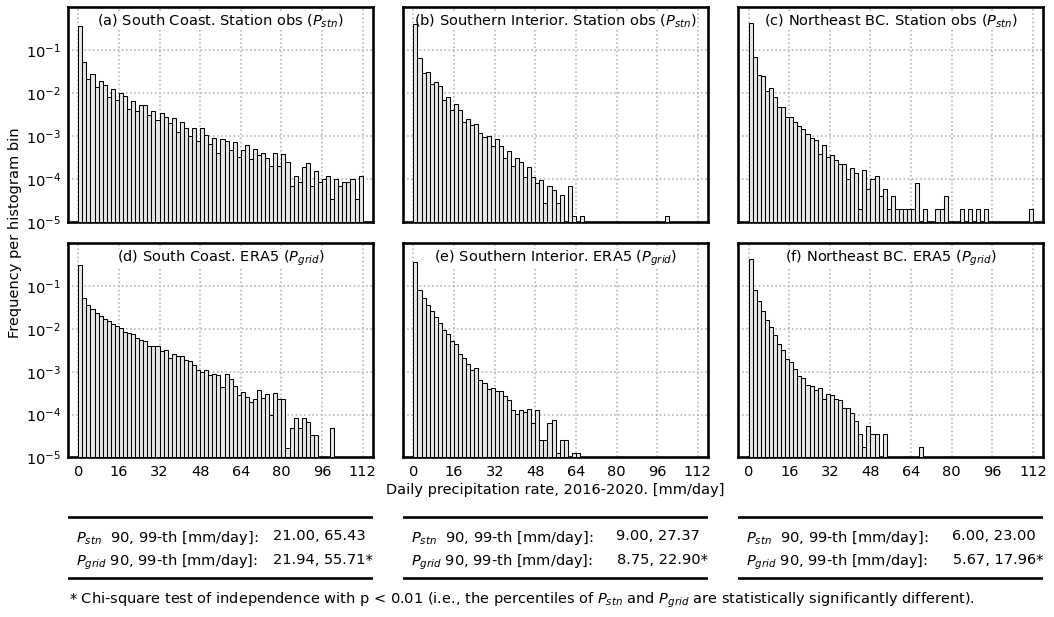

In [12]:
gray = '0.9'
window_size = 31
N_days = 366 + 365*3
N_effective = int(N_days/window_size)
seed_ = 999

fig = plt.figure(figsize=(13, 6), dpi=dpi_)
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1])

ax00 = plt.subplot(gs[0, 0])
ax01 = plt.subplot(gs[0, 1])
ax02 = plt.subplot(gs[0, 2])

ax10 = plt.subplot(gs[1, 0])
ax11 = plt.subplot(gs[1, 1])
ax12 = plt.subplot(gs[1, 2])

pad = 0.0
ax_a1 = fig.add_axes([0.0-pad, -0.275, 1/3.2+pad, 0.15])
ax_a2 = fig.add_axes([1.1/3.2-pad, -0.275, 1/3.2+pad, 0.15])
ax_a3 = fig.add_axes([2.2/3.2-pad, -0.275, 1/3.2+pad, 0.15])

plt.subplots_adjust(0, 0, 1, 1, hspace=0.1, wspace=0.1)

AX_obs = [ax00, ax01, ax02]
AX_era = [ax10, ax11, ax12]
AX_all = AX_obs+AX_era

# AX of analyzed stats
AX_a = [ax_a1, ax_a2, ax_a3]

handle_text = []

TITLE_obs = ['(a) South Coast. Station obs ($P_{stn}$)', 
             '(b) Southern Interior. Station obs ($P_{stn}$)', 
             '(c) Northeast BC. Station obs ($P_{stn}$)']
TITLE_era = ['(d) South Coast. ERA5 ($P_{grid}$)', 
             '(e) Southern Interior. ERA5 ($P_{grid}$)', 
             '(f) Northeast BC. ERA5 ($P_{grid}$)']

x_pdf = [8.0*np.arange(0, 14.2, 0.2), 8.0*np.arange(0, 14.2, 0.2), 8.0*np.arange(0, 14.2, 0.2)]
XTICKs = 8.0*np.arange(0, 16, 2)

for i, ax in enumerate(AX_all):
    ax = gu.ax_decorate_box(ax)
    ax.grid(linestyle=':', linewidth=1.5)
    ax.tick_params(labelleft=False)
    
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e0])
    ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    
    ax.set_xlim([8.0*-0.5, 8.0*14.5])
    ax.set_xticks(XTICKs)
    
ax00.tick_params(labelleft=True)
ax10.tick_params(labelleft=True)

ax00.set_ylabel('Frequency per histogram bin', y=-0.05, fontsize=14)

for i, ax in enumerate(AX_obs):
    ax.tick_params(labelbottom=False)
    
    obs_ = BCH_obs[:, FLAGs[i]].flatten()
    flag_nan = np.isnan(obs_)
    
    obs_ = obs_[~flag_nan]
    x_pdf_ = x_pdf[i]
    hist_, bins_ = np.histogram(obs_, bins=x_pdf_, density=True)
    
    ax.bar(bins_[:-1], hist_, align='edge', width=1.6, facecolor=gray, edgecolor='k', linewidth=1.0, zorder=4)

    handle_text.append(ax.text(0.5, 0.975, TITLE_obs[i], ha='center', va='top', fontsize=14, transform=ax.transAxes))

    
for i, ax in enumerate(AX_era):
    ax.tick_params(labelbottom=True)
    
    obs_ = ERA5_obs[:, FLAGs[i]].flatten()
    flag_nan = np.isnan(obs_)
    
    obs_ = obs_[~flag_nan]
    x_pdf_ = x_pdf[i]
    hist_, bins_ = np.histogram(obs_, bins=x_pdf_, density=True)

    ax.bar(bins_[:-1], hist_, align='edge', width=1.6, facecolor=gray, edgecolor='k', linewidth=1.0, zorder=4)

    handle_text.append(ax.text(0.5, 0.975, TITLE_era[i], ha='center', va='top', fontsize=14, transform=ax.transAxes))

    if i == 1:
        ax.set_xlabel('Daily precipitation rate, 2016-2020. [mm/day]', fontsize=14)

# ---------- stats ---------- #
for i, ax in enumerate(AX_a):
    temp1 = BCH_obs[:, FLAGs[i]].flatten()
    temp2 = ERA5_obs[:, FLAGs[i]].flatten()
    
    flag_nan = np.isnan(temp1)
    temp1 = temp1[~flag_nan]
    temp2 = temp2[~flag_nan]

    AX_a[i].text(0.025, 0.775, r'$P_{stn}$  90, 99-th [mm/day]:', 
                 ha='left', va='top', fontsize=14, transform=AX_a[i].transAxes)
    AX_a[i].text(0.975, 0.775, '{:.2f}, {:.2f}'.format(np.quantile(temp1, 0.9), 
                                                       np.quantile(temp1, 0.99)), 
                 ha='right', va='top', fontsize=14, transform=AX_a[i].transAxes)
    
    AX_a[i].text(0.025, 0.425, r'$P_{grid}$ 90, 99-th [mm/day]:', 
                 ha='left', va='top', fontsize=14, transform=AX_a[i].transAxes)

    AX_a[i].text(1.0, 0.425, '{:.2f}, {:.2f}*'.format(np.quantile(temp2, 0.9), 
                                                      np.quantile(temp2, 0.99)), 
                 ha='right', va='top', fontsize=14, transform=AX_a[i].transAxes)        


    AX_a[i].axhline(y=0.95, xmin=0, xmax=1.0, color='k', linewidth=2.5)
    AX_a[i].axhline(y=0.05, xmin=0, xmax=1.0, color='k', linewidth=2.5)
    
    AX_a[i].set_axis_off()

ax_t1 = fig.add_axes([0.001, -0.325, 0.999, 0.03])
ax_t1.set_axis_off()
handle_text.append(ax_t1.text(0.0, 1, 
                              '* Chi-square test of independence with p < 0.01 '+\
                              '(i.e., the percentiles of $P_{stn}$ and $P_{grid}$ are statistically significantly different).', 
                              ha='left', va='top', fontsize=14, transform=ax_t1.transAxes))

for handle in handle_text:
    handle.set_bbox(dict(facecolor='w', pad=0, edgecolor='none', zorder=6))
    
if need_publish:
    # Save figure
    fig.savefig(fig_dir+'AnEn_BCH_ERA5_part1.png', format='png', **fig_keys)

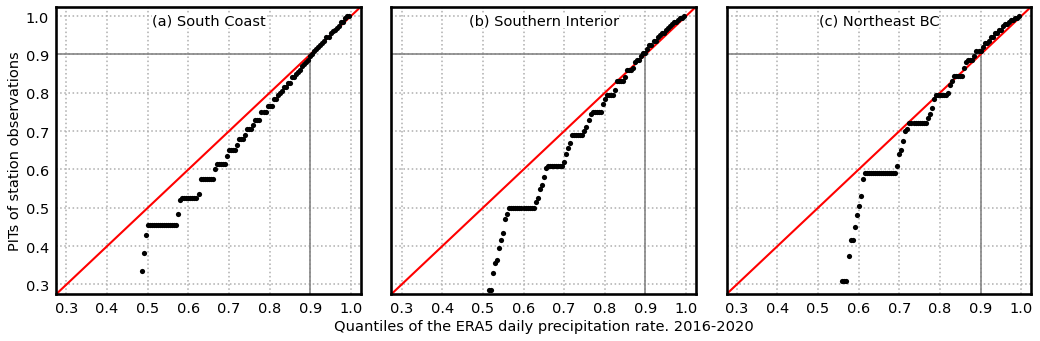

In [13]:
fig = plt.figure(figsize=(13, 13/3-0.5), dpi=dpi_)
gs = gridspec.GridSpec(1, 3, height_ratios=[1,], width_ratios=[1, 1, 1])

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[0, 2])

plt.subplots_adjust(0, 0, 1, 1, hspace=0.1, wspace=0.1)
AX = [ax0, ax1, ax2]

handle_text = []

TITLE = ['(a) South Coast', 
         '(b) Southern Interior', 
         '(c) Northeast BC']

for i, ax in enumerate(AX):
    ax = gu.ax_decorate_box(ax)
    ax.grid(linestyle=':', linewidth=1.5)
    ax.tick_params(labelbottom=True)
    ax.set_ylim([0.275, 1.025])
    ax.set_xlim([0.275, 1.025])
    ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.hlines(0.9, xmin=0.275, xmax=0.9, color='gray', linewidth=1.5)
    ax.vlines(0.9, ymin=0.275, ymax=0.9, color='gray', linewidth=1.5)
    handle_text.append(ax.text(0.5, 0.975, TITLE[i], ha='center', va='top', fontsize=14, transform=ax.transAxes))
    if i == 1:
        ax.set_xlabel('Quantiles of the ERA5 daily precipitation rate. 2016-2020', fontsize=14)
    if i == 0:
        ax.set_ylabel('PITs of station observations', fontsize=14)
ax0.tick_params(labelleft=True)

fake_x = np.linspace(0, 2, 100) # ref line

for i, key in enumerate(['sw', 'si', 'n']):
    AX[i].plot(q_bins, PIT[key], 'k.', ms=10, mew=0, zorder=4)
    AX[i].plot(fake_x, fake_x, 'r-', lw=2.0)
    
for handle in handle_text:
    handle.set_bbox(dict(facecolor='w', pad=0, edgecolor='none', zorder=6))
    
# ax_t1 = fig.add_axes([0.001, -0.2, 0.999, 0.03])
# ax_t1.set_axis_off()
# handle_text.append(ax_t1.text(0.0, 1, 
#                               'The Probability Integral Transform (PIT) is shown from 0.5 to 1.0.\n'+\
#                               'Precipitation values within [0, 0.5] quantile ranges have massive zeros and are not strcikly continuous.', 
#                               ha='left', va='top', fontsize=14, transform=ax_t1.transAxes))

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'AnEn_BCH_ERA5_part3.png', format='png', **fig_keys)

# Full-spectra analysis on 3 hourly

In [14]:
with h5py.File(save_dir+'BCH_ERA5_3H_pairs.hdf', 'r') as h5io:
    ERA5_obs = h5io['ERA5_obs'][...]
    BCH_obs = h5io['BCH_obs'][...]
    
ERA5_obs = ERA5_obs
BCH_obs = BCH_obs

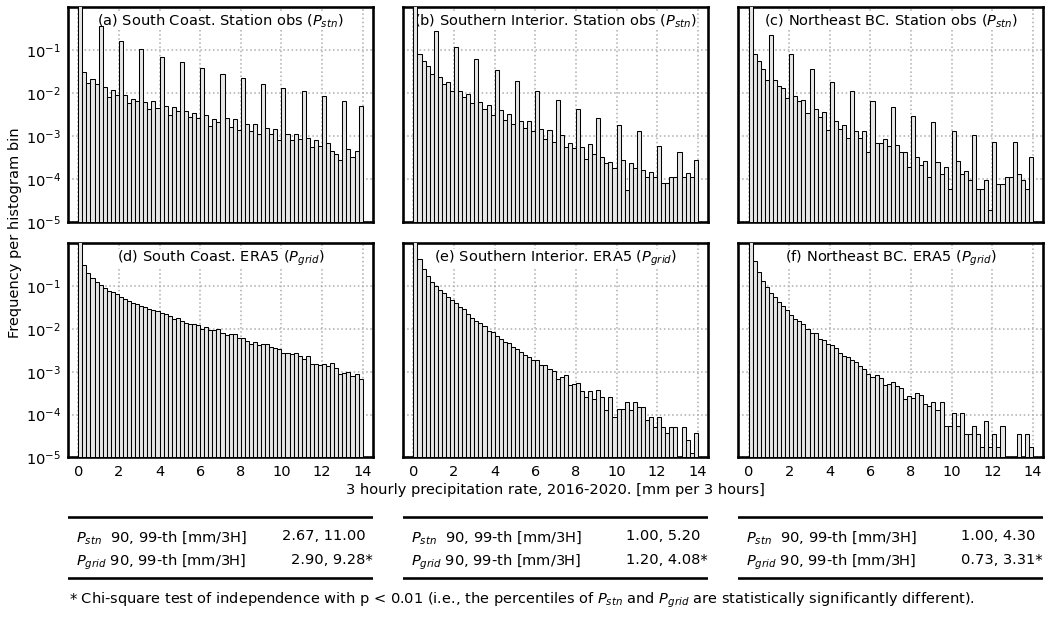

In [15]:

fig = plt.figure(figsize=(13, 6), dpi=dpi_)
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1])

ax00 = plt.subplot(gs[0, 0])
ax01 = plt.subplot(gs[0, 1])
ax02 = plt.subplot(gs[0, 2])

ax10 = plt.subplot(gs[1, 0])
ax11 = plt.subplot(gs[1, 1])
ax12 = plt.subplot(gs[1, 2])

pad = 0.0
ax_a1 = fig.add_axes([0.0-pad, -0.275, 1/3.2+pad, 0.15])
ax_a2 = fig.add_axes([1.1/3.2-pad, -0.275, 1/3.2+pad, 0.15])
ax_a3 = fig.add_axes([2.2/3.2-pad, -0.275, 1/3.2+pad, 0.15])

plt.subplots_adjust(0, 0, 1, 1, hspace=0.1, wspace=0.1)

AX_obs = [ax00, ax01, ax02]
AX_era = [ax10, ax11, ax12]
AX_all = AX_obs+AX_era

# AX of analyzed stats
AX_a = [ax_a1, ax_a2, ax_a3]

handle_text = []

TITLE_obs = ['(a) South Coast. Station obs ($P_{stn}$)', 
             '(b) Southern Interior. Station obs ($P_{stn}$)', 
             '(c) Northeast BC. Station obs ($P_{stn}$)']
TITLE_era = ['(d) South Coast. ERA5 ($P_{grid}$)', 
             '(e) Southern Interior. ERA5 ($P_{grid}$)', 
             '(f) Northeast BC. ERA5 ($P_{grid}$)']

x_pdf = [np.arange(0, 14.2, 0.2), np.arange(0, 14.2, 0.2), np.arange(0, 14.2, 0.2)]
XTICKs = np.arange(0, 16, 2)

for i, ax in enumerate(AX_all):
    ax = gu.ax_decorate_box(ax)
    ax.grid(linestyle=':', linewidth=1.5)
    ax.tick_params(labelleft=False)
    
    ax.set_yscale('log')
    ax.set_ylim([1e-5, 1e0])
    ax.set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    
    ax.set_xlim([-0.5, 14.5])
    ax.set_xticks(XTICKs)
    
ax00.tick_params(labelleft=True)
ax10.tick_params(labelleft=True)

ax00.set_ylabel('Frequency per histogram bin', y=-0.05, fontsize=14)

for i, ax in enumerate(AX_obs):
    ax.tick_params(labelbottom=False)
    
    obs_ = BCH_obs[:, FLAGs[i]].flatten()
    flag_nan = np.isnan(obs_)
    
    obs_ = obs_[~flag_nan]
    x_pdf_ = x_pdf[i]
    hist_, bins_ = np.histogram(obs_, bins=x_pdf_, density=True)
    
    ax.bar(bins_[:-1], hist_, align='edge', width=0.2, facecolor=gray, edgecolor='k', linewidth=1.0, zorder=4)

    handle_text.append(ax.text(0.5, 0.975, TITLE_obs[i], ha='center', va='top', fontsize=14, transform=ax.transAxes))

    
for i, ax in enumerate(AX_era):
    ax.tick_params(labelbottom=True)
    
    obs_ = ERA5_obs[:, FLAGs[i]].flatten()
    flag_nan = np.isnan(obs_)
    
    obs_ = obs_[~flag_nan]
    x_pdf_ = x_pdf[i]
    hist_, bins_ = np.histogram(obs_, bins=x_pdf_, density=True)

    ax.bar(bins_[:-1], hist_, align='edge', width=0.2, facecolor=gray, edgecolor='k', linewidth=1.0, zorder=4)

    handle_text.append(ax.text(0.5, 0.975, TITLE_era[i], ha='center', va='top', fontsize=14, transform=ax.transAxes))

    if i == 1:
        ax.set_xlabel('3 hourly precipitation rate, 2016-2020. [mm per 3 hours]', fontsize=14)

# ---------- stats ---------- #
for i, ax in enumerate(AX_a):
    temp1 = BCH_obs[:, FLAGs[i]].flatten()
    temp2 = ERA5_obs[:, FLAGs[i]].flatten()
    
    flag_nan = np.isnan(temp1)
    temp1 = temp1[~flag_nan]
    temp2 = temp2[~flag_nan]

    AX_a[i].text(0.025, 0.775, r'$P_{stn}$  90, 99-th [mm/3H]', 
                 ha='left', va='top', fontsize=14, transform=AX_a[i].transAxes)
    AX_a[i].text(0.975, 0.775, '{:.2f}, {:.2f}'.format(np.quantile(temp1, 0.9), 
                                                       np.quantile(temp1, 0.99)), 
                 ha='right', va='top', fontsize=14, transform=AX_a[i].transAxes)
    
    AX_a[i].text(0.025, 0.425, r'$P_{grid}$ 90, 99-th [mm/3H]', 
                 ha='left', va='top', fontsize=14, transform=AX_a[i].transAxes)

    AX_a[i].text(1.0, 0.425, '{:.2f}, {:.2f}*'.format(np.quantile(temp2, 0.9), 
                                                      np.quantile(temp2, 0.99)), 
                 ha='right', va='top', fontsize=14, transform=AX_a[i].transAxes)        


    AX_a[i].axhline(y=0.95, xmin=0, xmax=1.0, color='k', linewidth=2.5)
    AX_a[i].axhline(y=0.05, xmin=0, xmax=1.0, color='k', linewidth=2.5)
    
    AX_a[i].set_axis_off()


ax_t1 = fig.add_axes([0.001, -0.325, 0.999, 0.03])
ax_t1.set_axis_off()
handle_text.append(ax_t1.text(0.0, 1, 
                              '* Chi-square test of independence with p < 0.01 '+\
                              '(i.e., the percentiles of $P_{stn}$ and $P_{grid}$ are statistically significantly different).', 
                              ha='left', va='top', fontsize=14, transform=ax_t1.transAxes))

for handle in handle_text:
    handle.set_bbox(dict(facecolor='w', pad=0, edgecolor='none', zorder=6))
    
if need_publish:
    # Save figure
    fig.savefig(fig_dir+'AnEn_BCH_ERA5_part2.png', format='png', **fig_keys)